[  15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.
   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.
   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.
   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.   74.
   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.
   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.
   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.
  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.
  123.  124.  125.  126.  127.  128.  129.  130.  131.  132.  133.  134.
  135.  136.  137.  138.  139.  140.  141.  142.  143.  144.  145.  146.]
[ 0.          0.03333333  0.06666667  0.1         0.13333333  0.16666667
  0.2         0.23333333  0.26666667  0.3         0.33333333  0.36666667
  0.4         0.43333333  0.46666667  0.5       ]


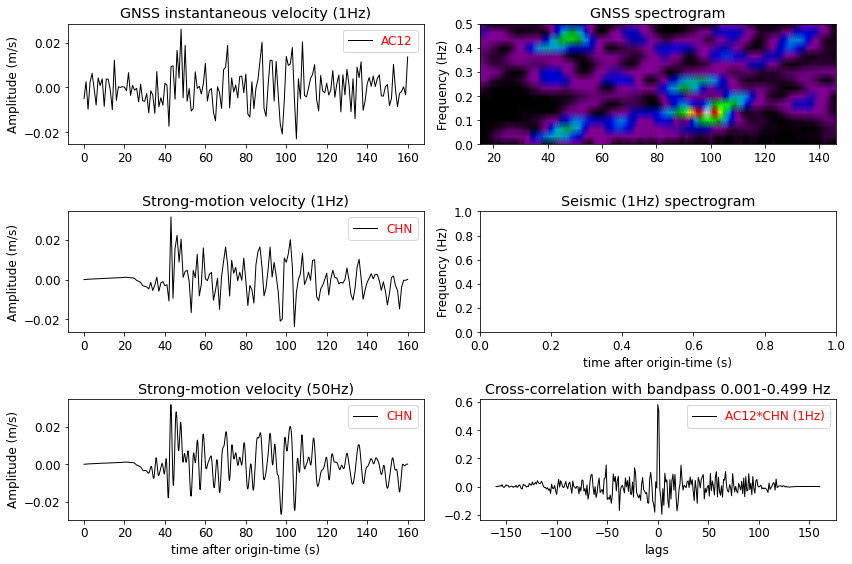

In [77]:
######## GNSS instavel Vs strong-motion derived velocity analysis and plots ##################
####################################### Goals ################################################
#     1) Read a GNSS instavel and convert it into an obspy stream
#     2) Filter instavel
#     3) Load acceleration from IRIS client
#     4) Filter and integrate strong-motion acceleration to corresponding velocity
#     5) Normalize all streams and plot
#     6) Include spectrograms and cross-correlation plots
##############################################################################################

from obspy import UTCDateTime 				
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.signal.cross_correlation import correlate
from obspy.clients.fdsn import Client 		
client=Client("IRIS")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from scipy import signal
import seaborn as sns

def compute_shift(cc):
    zero_index = int(len(cc) / 2) - 1
    shift = zero_index - np.argmax(cc)
    return shift

# READ INSTAVEL ASCII FILE
infile = 'Chignik_phase_vels/ac12_1hz.L2.igr.phase_vels'
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx', 'vy', 'vz', 'sigx', 'sigy', 'sigz', 'vdt', 'vn', 've', 'vu', 'sign', 'sige', 'sigu'])

# CREATE AN EMPTY STREAM AND POPULATE WITH INSTAVEL DATA
st_gnss_vz = Stream(Trace())
st_gnss_vz[0].stats.network = '--'
st_gnss_vz[0].stats.station = 'AC12'
st_gnss_vz[0].stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
st_gnss_vz[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_vz[0].stats.sampling_rate = 1
st_gnss_vz[0].stats.calib = 1
st_gnss_vz[0].data = site['ve']
st_gnss_vz[0].detrend('linear')
st_gnss_vz[0].detrend('demean')
dt = UTCDateTime("2021-07-29T06:15:49.000000Z")
st_gnss_vz[0].trim(dt, dt+160)
#st_gnss_vz[0].plot()
#print(st_gnss_vz[0].max())

# TIDY UP GNSS VELOCITY TRACE -- FILTER THE HECK OUTTA THAT THING!!!!!!!!!!!
st_gnss_vz[0].filter('bandpass', freqmin=0.001, freqmax=0.499, corners=4, zerophase=True)
#st_gnss_vz[0].plot()
#print(st_gnss_vz[0].max())
#st_gnss_vz[0].filter('lowpass', freq=0.45, corners=2, zerophase=True)

# LOAD ONE SEISMIC ACCELERATION STREAM FROM IRIS DMC
start = UTCDateTime("2021-07-29T06:15:49.008400Z")
st_seis_az = client.get_waveforms('AK', 'CHN', "*", 'BNE', (start), (start+160), attach_response=True)
#st_seis_az[0].plot()
#print(st_seis_az[0].max())

############ What's-in-there flags ################################
### The nearest strong-motion time-stamps are rounded to the ######
### corresponding GNSS ones. 'print' lines help with this #########
#print(st_seis_az[0].data)
#print(len(st_seis_az[0]))
#print(st_seis_az[0].stats.starttime)
#print(st_seis_az[0].times("utcdatetime"))
####################################################################

# TIDY UP ACCELERATION TRACE
st_seis_az[0].remove_response(inventory=None, output="ACC", plot=False)
st_seis_az[0].detrend('linear')
st_seis_az[0].filter('bandpass', freqmin=0.001, freqmax=0.499, corners=4, zerophase=True)
#st_seis_az[0].filter('lowpass', freq=5, corners=2, zerophase=True)
#st_seis_az[0].plot()
#print(st_seis_az[0].max())

# CREATE A SEISMIC VELOCITY TRACE
st_seis_vz = st_seis_az[0].copy()
st_seis_vz.integrate(method='cumtrapz')
hz = st_seis_vz.data[::50]   # Brute-force 'downsampling' of strong-motion derived velocity to 1 Hz post-filtering and -integration
#st_seis_vz.plot()
#print(st_seis_vz.max())

# CREATE AN EMPTY STREAM AND POPULATE WITH 1Hz STRONG-MOTION DERIVED VELOCITY DATA
st_sm_vz = Stream(Trace())
st_sm_vz[0].stats.network = 'AK'
st_sm_vz[0].stats.station = 'CHN'
st_sm_vz[0].stats.channel = 'BNE'    
st_sm_vz[0].stats.starttime = UTCDateTime("2021-07-29T06:15:49.0Z")
st_sm_vz[0].stats.sampling_rate = 1
st_sm_vz[0].stats.calib = 1
st_sm_vz[0].data = hz

# NORMALIZE EACH TRACE WITH ITS ABSOLUTE MAXIMUM
#st_seis_vz.normalize()
#st_sm_vz[0].normalize()
#st_gnss_vz[0].normalize()

# CROSS CORRELATION
lags = np.arange(-160, 161)  
cc = correlate(st_gnss_vz[0].data, st_sm_vz[0].data, 160)
#print(max(cc))
#print(compute_shift(cc))

# CREATE STREAMS WITH ALL TRACES AND PLOT THEM
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size': 12})
#plt.style.use('seaborn')

fig, axx = plt.subplots(3,2, sharex=False, sharey=False)
axx[0, 0].plot(st_gnss_vz[0].times(), st_gnss_vz[0].data, 'k-', linewidth=1, label=st_gnss_vz[0].stats['station'])
axx[1, 0].plot(st_sm_vz[0].times(), st_sm_vz[0].data, 'k-', linewidth=1, label=st_sm_vz[0].stats['station'])
axx[2, 0].plot(st_seis_vz.times(), st_seis_vz.data, 'k-', linewidth=1, label=st_seis_vz.stats['station'])
axx[0, 0].set_title(f'GNSS instantaneous velocity (1Hz)')
axx[1, 0].set_title(f'Strong-motion velocity (1Hz)')
axx[2, 0].set_title(f'Strong-motion velocity (50Hz)')
axx[0, 0].set_ylabel('Amplitude (m/s)')
axx[1, 0].set_ylabel('Amplitude (m/s)')
axx[2, 0].set_ylabel('Amplitude (m/s)')


f, t, Sxx = signal.spectrogram(st_gnss_vz[0].data, fs=st_gnss_vz[0].stats.sampling_rate, mode='psd', window=('tukey', 30), nperseg=30, noverlap=29.7, scaling='density')
print(t)
print(f)
print(Sxx)
#axx[0, 1] = sns.heatmap(np.log(Sxx[::-1, :]), cmap = 'nipy_spectral', ax= axx[0,1], vmin=0, vmax=0.1)
#axx[0, 1].specgram(st_sm_vz[0].data,Fs=st_sm_vz[0].stats.sampling_rate) 
axx[0, 1].pcolormesh(t, f, Sxx, shading='gouraud', cmap='nipy_spectral', vmin=np.min(Sxx), vmax=np.max(Sxx))

#st_gnss_vz[0].spectrogram(log=False, dbscale=False, wlen=30, show=False, axes=axx[0, 1], 
#                          samp_rate=st_gnss_vz[0].stats.sampling_rate, per_lap=0.99, cmap='nipy_spectral')
#mappable = axx[0,1].images[0]
#ax33 = fig.add_axes([0.95, 0.731, 0.01, 0.217])
#plt.colorbar(mappable=mappable, cax=ax33)
#st_sm_vz[0].spectrogram(log=False, dbscale=False, wlen=30, show=False, axes=axx[1, 1], 
#                        samp_rate=st_sm_vz[0].stats.sampling_rate, per_lap=0.99, cmap='nipy_spectral')
#mappable = axx[1,1].images[0]
#ax23 = fig.add_axes([0.95, 0.405, 0.01, 0.217])
plt.colorbar(mappable=mappable, cax=ax23)
axx[2, 1].plot(lags, cc, 'k', linewidth=1, label='AC12*CHN (1Hz)')
axx[0, 1].set_title(f'GNSS spectrogram')
axx[1, 1].set_title(f'Seismic (1Hz) spectrogram')
axx[2, 1].set_title(f'Cross-correlation with bandpass 0.001-0.499 Hz') #Cross-correlation for bandpass 0.001-0.5 Hz
axx[1, 1].set_xlabel('time after origin-time (s)')
#axx[0, 0].set_xlabel('time 20s after origin-time (s)')
axx[2, 0].set_xlabel('time after origin-time (s)')
axx[2, 1].set_xlabel('lags')
axx[0, 1].set_ylabel('Frequency (Hz)')
axx[1, 1].set_ylabel('Frequency (Hz)')
plt.tight_layout()

# TRACE LEGENDS
for row in axx[:,0]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend

ll = axx[2,1].legend(loc=1)
plt.setp(ll.get_texts(), color='red') #color legend

plt.show()
